<a href="https://colab.research.google.com/github/angelrecalde2024/Power-System-Planning-and-Transmission-Design-2026/blob/main/LDCwithGenerationExpansionPlan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# This will open a file selection dialog. Choose your 'DataForLDCandGenerationExpansion.xlsx' file.
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


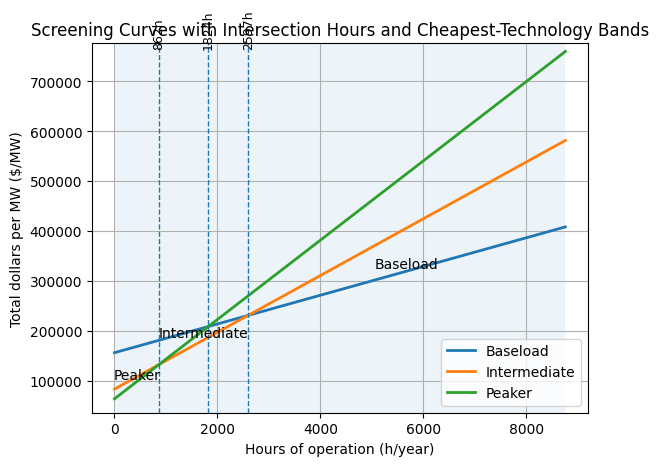

Parsed existing units: 11
Parsed candidate techs: Baseload, Intermediate, Peaker
--------------------------------------------------------------------------------
STEP 4 - Screening curves (per MW): C(h)=Fixed + Var*h
  - Baseload: Fixed=$155,738.00/MW, Var=$28.80/MWh
  - Intermediate: Fixed=$82,736.00/MW, Var=$56.91/MWh
  - Peaker: Fixed=$63,270.00/MW, Var=$79.50/MWh

Intersections within [0, 8760] hours:
  - Intermediate x Peaker: h*=861.7 h, cost=$131,775.84/MW
  - Baseload x Peaker: h*=1,823.8 h, cost=$208,264.20/MW
  - Baseload x Intermediate: h*=2,597.0 h, cost=$230,531.94/MW

Verification vs expected intersection hours:
  - expected ~862.0 h -> closest 861.7 h (Δ=0.3 h) [OK]  (Intermediate x Peaker)
  - expected ~2,567.0 h -> closest 2,597.0 h (Δ=30.0 h) [OK]  (Baseload x Intermediate)
--------------------------------------------------------------------------------


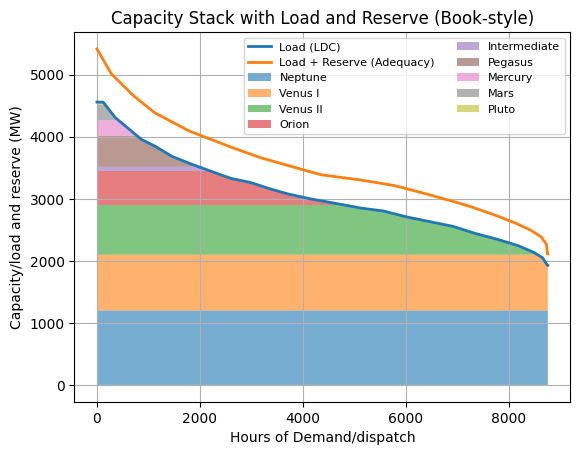

YEAR 5
  Reserve curve treated as Load+Reserve
  Existing capacity sum: 5350.00 MW
  Eligible new techs (deploy_time<=year):
    - Intermediate: var=$56.91/MWh, fixed=$82736.00/MW, maxcap=500.00 MW, built=66.00 MW
    - Peaker: var=$79.50/MWh, fixed=$63270.00/MW, maxcap=250.00 MW, built=0.00 MW
  Fixed cost total:    $5460576.00
  Variable cost total: $848701073.87
  TOTAL cost:          $854161649.87
  Top energy (MWh):
    - Neptune: 10500000.00 MWh
    - Venus I: 7867823.26 MWh
    - Venus II: 5710556.46 MWh
    - Orion: 1938853.68 MWh
    - Pegasus: 734737.59 MWh
    - Mercury: 170738.88 MWh
    - Intermediate: 147708.00 MWh
    - Mars: 90101.85 MWh
--------------------------------------------------------------------------------


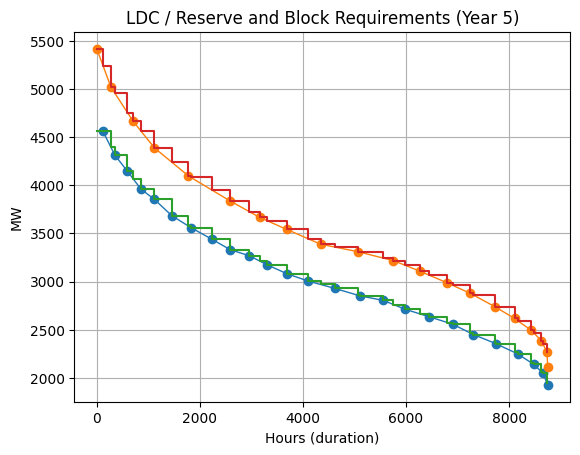

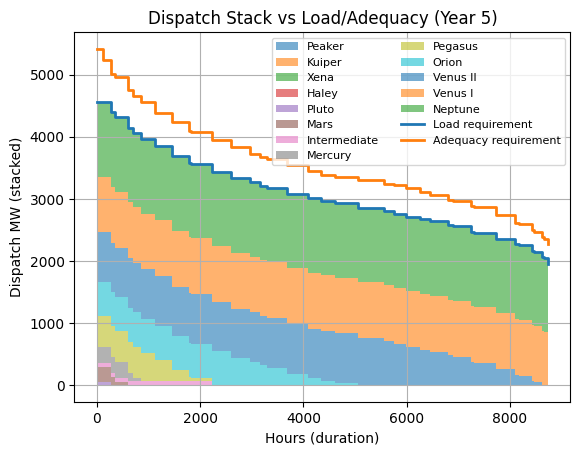

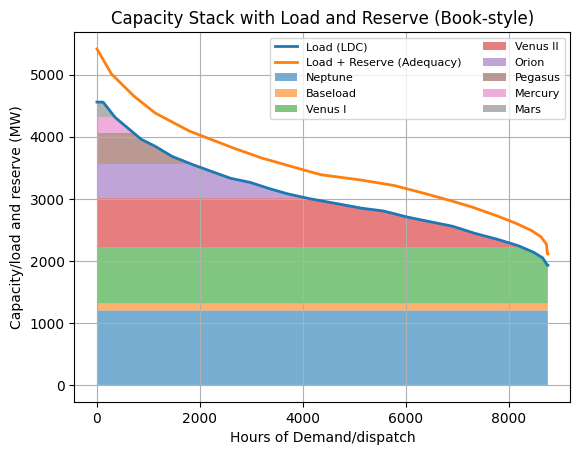

YEAR 6
  Reserve curve treated as Load+Reserve
  Existing capacity sum: 5350.00 MW
  Eligible new techs (deploy_time<=year):
    - Baseload: var=$28.80/MWh, fixed=$155738.00/MW, maxcap=900.00 MW, built=112.00 MW
    - Intermediate: var=$56.91/MWh, fixed=$82736.00/MW, maxcap=500.00 MW, built=0.00 MW
    - Peaker: var=$79.50/MWh, fixed=$63270.00/MW, maxcap=250.00 MW, built=0.00 MW
  Fixed cost total:    $17442656.00
  Variable cost total: $831351146.35
  TOTAL cost:          $848793802.35
  Top energy (MWh):
    - Neptune: 10500000.00 MWh
    - Venus I: 7841134.04 MWh
    - Venus II: 5275242.09 MWh
    - Orion: 1671513.26 MWh
    - Baseload: 980000.00 MWh
    - Pegasus: 671165.59 MWh
    - Mercury: 158732.88 MWh
    - Mars: 74556.85 MWh
--------------------------------------------------------------------------------


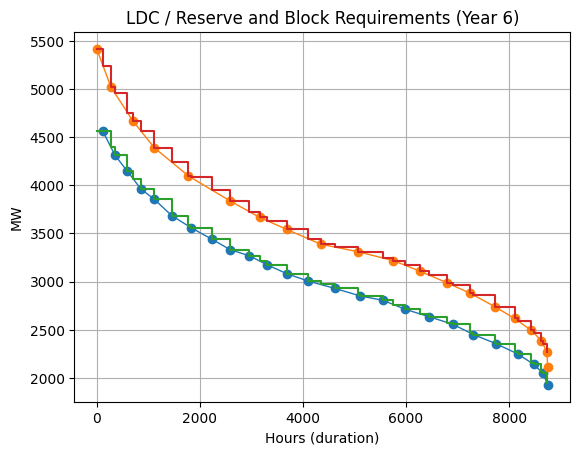

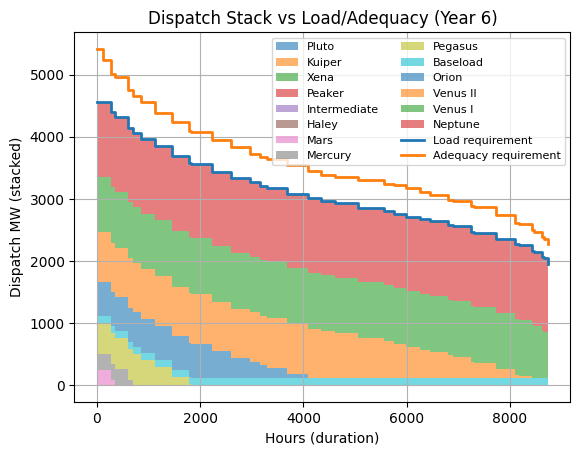

In [7]:
# /gep_ldc_lp.py
"""
Generation Expansion Planning (single-year) using LDC + Reserve curve as LP.

(Updated) Adds STEP 4 screening-curve intersection reporting + verification.
"""

from __future__ import annotations

import os
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.optimize import linprog
except Exception as exc:
    raise RuntimeError(
        "scipy is required. In Google Colab, run: !pip -q install scipy"
    ) from exc


@dataclass(frozen=True)
class Curve:
    hours: np.ndarray
    mw: np.ndarray


@dataclass(frozen=True)
class ExistingUnit:
    name: str
    cap_mw: float
    var_cost: float


@dataclass(frozen=True)
class NewTech:
    name: str
    var_cost: float
    fixed_cost: float
    deploy_time_years: int


@dataclass(frozen=True)
class Block:
    h0: float
    h1: float
    duration: float
    load_mw: float
    adequacy_mw: float


@dataclass(frozen=True)
class Intersection:
    tech_a: str
    tech_b: str
    hour: float
    cost_at_hour: float


def _read_curve(df: pd.DataFrame, hour_col: str = "Hour", mw_col: str = "Power (MW)") -> Curve:
    """
    Parse a duration-curve sheet into a Curve(hours, MW).

    Inputs:
      df: DataFrame containing at least `hour_col` and `mw_col`.
      hour_col: Column name for duration (hours). Must be numeric or convertible.
      mw_col: Column name for power (MW). Must be numeric or convertible.

    Outputs:
      Curve with:
        - hours: ascending numpy array of hour coordinates
        - mw: numpy array of MW values aligned with `hours`

    Purpose / objective:
      Standardize LDC/RDC sheet data so the model can interpolate and build dispatch blocks.
    """
    d = df[[hour_col, mw_col]].copy()
    d[hour_col] = pd.to_numeric(d[hour_col], errors="coerce")
    d[mw_col] = pd.to_numeric(d[mw_col], errors="coerce")
    d = d.dropna().sort_values(hour_col)
    if d.empty:
        raise ValueError("Curve sheet is empty or invalid.")
    return Curve(hours=d[hour_col].to_numpy(dtype=float), mw=d[mw_col].to_numpy(dtype=float))


def _interp_hold_endpoints(curve: Curve, x: np.ndarray) -> np.ndarray:
    """
    Interpolate a Curve on new x-coordinates with endpoint holding.

    Inputs:
      curve: Curve(hours, mw) with strictly increasing `hours`.
      x: numpy array of hour positions where interpolation is required.

    Outputs:
      y: numpy array of MW values at each x.

    Purpose / objective:
      Provide stable curve sampling for block construction.
      - Uses linear interpolation inside the curve range.
      - Holds the first/last values constant outside the curve range.
    """
    xp, fp = curve.hours, curve.mw
    return np.interp(x, xp, fp, left=fp[0], right=fp[-1])


def _read_existing_units(path: str) -> List[ExistingUnit]:
    """
    Read existing/planned generation units from the 'Existing' sheet.

    Inputs:
      path: Path to the Excel workbook.

    Outputs:
      List[ExistingUnit] where each unit includes:
        - name: unit identifier
        - cap_mw: maximum capacity in MW
        - var_cost: total variable cost in $/MWh

    Purpose / objective:
      Load all fixed-capacity resources that participate in dispatch and adequacy
      for all study years (per your assumption that all existing are available in year 5 and 6).
    """
    df = pd.read_excel(path, sheet_name="Existing", header=1)
    df = df.rename(columns=lambda c: str(c).strip())
    req = ["Unit Name", "Max capacity (MW)", "Total variable cost ($/MWh)"]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"'Existing' sheet missing columns: {missing}")

    df["Max capacity (MW)"] = pd.to_numeric(df["Max capacity (MW)"], errors="coerce")
    df["Total variable cost ($/MWh)"] = pd.to_numeric(df["Total variable cost ($/MWh)"], errors="coerce")
    df = df.dropna(subset=["Unit Name", "Max capacity (MW)", "Total variable cost ($/MWh)"])

    units: List[ExistingUnit] = []
    for _, r in df.iterrows():
        units.append(
            ExistingUnit(
                name=str(r["Unit Name"]).strip(),
                cap_mw=float(r["Max capacity (MW)"]),
                var_cost=float(r["Total variable cost ($/MWh)"]),
            )
        )
    return units


def _read_new_techs(path: str) -> List[NewTech]:
    """
    Read candidate (new) technology definitions from 'New-variable' and 'New-fixed'.

    Inputs:
      path: Path to the Excel workbook.

    Outputs:
      List[NewTech] where each technology includes:
        - name: technology identifier
        - var_cost: total variable cost in $/MWh (from 'New-variable')
        - fixed_cost: fixed cost in $/MW (NPV) (from 'New-fixed')
        - deploy_time_years: development/construction timeline in years

    Purpose / objective:
      Build the technology set available for expansion decisions.
      These are decision variables in the LP (capacity + dispatch).
    """
    df_var = pd.read_excel(path, sheet_name="New-variable", header=2)
    if df_var.shape[1] < 7:
        raise ValueError("Unexpected 'New-variable' layout. Need at least 7 columns.")
    df_var = df_var.rename(columns={df_var.columns[0]: "Tech", df_var.columns[6]: "VarCost"})
    df_var["Tech"] = df_var["Tech"].astype(str).str.strip()
    df_var["VarCost"] = pd.to_numeric(df_var["VarCost"], errors="coerce")
    df_var = df_var.dropna(subset=["Tech", "VarCost"])

    df_fix = pd.read_excel(path, sheet_name="New-fixed", header=1)
    df_fix = df_fix.rename(columns=lambda c: str(c).strip())
    req = ["Unit type", "Fixed cost ($/MW)", "Deployment time in years"]
    missing = [c for c in req if c not in df_fix.columns]
    if missing:
        raise ValueError(f"'New-fixed' sheet missing columns: {missing}")

    df_fix["Unit type"] = df_fix["Unit type"].astype(str).str.strip()
    df_fix["Fixed cost ($/MW)"] = pd.to_numeric(df_fix["Fixed cost ($/MW)"], errors="coerce")
    df_fix["Deployment time in years"] = pd.to_numeric(df_fix["Deployment time in years"], errors="coerce")
    df_fix = df_fix.dropna(subset=["Unit type", "Fixed cost ($/MW)", "Deployment time in years"])

    fix_map: Dict[str, Tuple[float, int]] = {
        str(r["Unit type"]).strip(): (float(r["Fixed cost ($/MW)"]), int(r["Deployment time in years"]))
        for _, r in df_fix.iterrows()
    }

    techs: List[NewTech] = []
    for _, r in df_var.iterrows():
        name = str(r["Tech"]).strip()
        if name not in fix_map:
            continue
        fixed_cost, deploy = fix_map[name]
        techs.append(NewTech(name=name, var_cost=float(r["VarCost"]), fixed_cost=fixed_cost, deploy_time_years=deploy))

    if not techs:
        raise ValueError("No new technologies could be parsed/merged from 'New-variable' and 'New-fixed'.")
    return techs


def read_input(workbook_path: str) -> Tuple[Curve, Curve, List[ExistingUnit], List[NewTech]]:
    """
    Read all required model inputs from the Excel workbook.

    Inputs:
      workbook_path: Path to the workbook.

    Outputs:
      (ldc, reserve, existing, new_techs) where:
        - ldc: Load Duration Curve
        - reserve: Reserve (or adequacy) duration curve
        - existing: list of existing units (fixed capacity)
        - new_techs: list of candidate technologies (build optional)

    Purpose / objective:
      Single entry point for parsing/validating the workbook data.
      Keeps I/O separate from the optimization model.
    """
    ldc = _read_curve(pd.read_excel(workbook_path, sheet_name="LDC"))
    reserve = _read_curve(pd.read_excel(workbook_path, sheet_name="Reserve"))
    existing = _read_existing_units(workbook_path)
    new_techs = _read_new_techs(workbook_path)
    return ldc, reserve, existing, new_techs


# -------------------------
# STEP 4: Screening curves
# -------------------------

def screening_cost(tech: NewTech, hours: float) -> float:
    """Per-MW total cost at given operating hours: Fixed($/MW) + Var($/MWh)*hours."""
    return float(tech.fixed_cost + tech.var_cost * hours)


def screening_intersections(
    techs: List[NewTech],
    hour_min: float = 0.0,
    hour_max: float = 8760.0,
) -> List[Intersection]:
    """
    Computes all pairwise screening-curve intersections within [hour_min, hour_max].
    Returns intersections sorted by hour.
    """
    out: List[Intersection] = []
    for i in range(len(techs)):
        for j in range(i + 1, len(techs)):
            a, b = techs[i], techs[j]
            denom = (a.var_cost - b.var_cost)
            if abs(denom) < 1e-12:
                continue
            h = (b.fixed_cost - a.fixed_cost) / denom
            if not np.isfinite(h):
                continue
            if h < hour_min or h > hour_max:
                continue
            cost = screening_cost(a, h)  # == screening_cost(b, h)
            out.append(Intersection(tech_a=a.name, tech_b=b.name, hour=float(h), cost_at_hour=float(cost)))
    out.sort(key=lambda x: x.hour)
    return out


def print_screening_report(
    techs: List[NewTech],
    expected_hours: Optional[List[float]] = None,
    tol_hours: float = 100.0,
    hour_max: float = 8760.0,
) -> None:
    """
    Prints screening curves summary + intersections and verifies expected breakpoints.
    expected_hours: e.g., [862, 2567]
    """
    techs_sorted = sorted(techs, key=lambda t: (t.var_cost, t.fixed_cost))
    print("STEP 4 - Screening curves (per MW): C(h)=Fixed + Var*h")
    for t in techs_sorted:
        print(f"  - {t.name}: Fixed=${t.fixed_cost:,.2f}/MW, Var=${t.var_cost:,.2f}/MWh")

    inter = screening_intersections(techs_sorted, hour_min=0.0, hour_max=hour_max)
    if not inter:
        print("No intersections found within the hour range.")
        return

    print("\nIntersections within [0, {0:.0f}] hours:".format(hour_max))
    for it in inter:
        print(f"  - {it.tech_a} x {it.tech_b}: h*={it.hour:,.1f} h, cost=${it.cost_at_hour:,.2f}/MW")

    if expected_hours:
        print("\nVerification vs expected intersection hours:")
        found_hours = np.array([it.hour for it in inter], dtype=float)
        for exp in expected_hours:
            idx = int(np.argmin(np.abs(found_hours - exp)))
            closest = float(found_hours[idx])
            delta = abs(closest - exp)
            ok = delta <= tol_hours
            tag = "OK" if ok else "CHECK"
            it = inter[idx]
            print(
                f"  - expected ~{exp:,.1f} h -> closest {closest:,.1f} h "
                f"(Δ={delta:,.1f} h) [{tag}]  ({it.tech_a} x {it.tech_b})"
            )


def build_blocks(
    ldc: Curve,
    reserve: Curve,
) -> Tuple[List[Block], bool]:
    """
    Convert LDC and Reserve curves into piecewise-constant dispatch/adequacy blocks.

    Inputs:
      ldc: Load duration curve Curve(hours, mw).
      reserve: Reserve duration curve Curve(hours, mw).

    Outputs:
      blocks: list of Block objects, each containing:
        - h0, h1: hour interval boundaries
        - duration: h1 - h0
        - load_mw: load requirement at the start of the block (conservative)
        - adequacy_mw: capacity adequacy requirement for the block
      reserve_includes_load:
        - True if the Reserve curve appears to already represent Load+Reserve
        - False if Reserve appears to be "reserve-only" and is added to LDC

    Purpose / objective:
      Build the time representation used by the LP:
      - each block is a demand level lasting `duration` hours
      - enforce load balance and adequacy per block (Option A).
    """
    hmax = float(max(ldc.hours.max(), reserve.hours.max()))
    hours = np.unique(np.concatenate(([0.0], ldc.hours, reserve.hours, [hmax])))
    hours = np.sort(hours)

    load_at = _interp_hold_endpoints(ldc, hours)
    res_at = _interp_hold_endpoints(reserve, hours)

    reserve_includes_load = bool(np.nanmedian(res_at - load_at) > 0.0)

    blocks: List[Block] = []
    for i in range(len(hours) - 1):
        h0, h1 = float(hours[i]), float(hours[i + 1])
        if h1 <= h0:
            continue
        duration = h1 - h0
        load_req = float(load_at[i])
        if reserve_includes_load:
            adequacy_req = float(res_at[i])
        else:
            adequacy_req = float(load_at[i] + res_at[i])
        blocks.append(Block(h0=h0, h1=h1, duration=duration, load_mw=load_req, adequacy_mw=adequacy_req))

    return blocks, reserve_includes_load


def default_new_max_caps(
    existing: List[ExistingUnit],
    eligible_new: List[NewTech],
) -> Dict[str, float]:
    """
    Compute default max build limits for new technologies.

    Inputs:
      existing: List of existing units with capacity and variable costs.
      eligible_new: List of new technologies eligible in the target year.

    Outputs:
      Dict mapping {tech_name: max_build_mw}.

    Purpose / objective:
      Implements your rule-of-thumb capacity limit:
        max(new tech) = capacity of the next more expensive existing unit
      (by variable cost). Used as upper bounds on capacity decision variables.
    """
    ex_sorted = sorted(existing, key=lambda u: u.var_cost)
    max_existing_cap = max(u.cap_mw for u in ex_sorted)

    caps: Dict[str, float] = {}
    for t in eligible_new:
        candidates = [u for u in ex_sorted if u.var_cost > t.var_cost]
        caps[t.name] = float(candidates[0].cap_mw) if candidates else float(max_existing_cap)
    return caps


def solve_year_lp(
    year: int,
    ldc: Curve,
    reserve: Curve,
    existing: List[ExistingUnit],
    new_techs: List[NewTech],
) -> Dict[str, object]:
    """
    Solve the single-year generation expansion + dispatch LP for a given horizon year.

    Inputs:
      year: study horizon year (e.g., 5 or 6). Determines technology eligibility via deploy_time_years.
      ldc: load duration curve.
      reserve: reserve/adequacy duration curve.
      existing: existing units (fixed capacity).
      new_techs: all candidate technologies (subset will be eligible).

    Outputs:
      result dict with:
        - built_cap: {tech: MW built} for eligible new technologies
        - dispatch_mw: 2D array [generator, block] with dispatch (MW)
        - energy_mwh: {generator: annual energy} computed from dispatch and block duration
        - fixed_cost_total, variable_cost_total, total_cost
        - blocks and metadata (eligible_new, bounds, etc.)

    Purpose / objective:
      Minimize single-year total cost:
        Σ(Fixed_NPV $/MW * capacity) + Σ(Var $/MWh * MWh dispatched)
      Subject to:
        - dispatch meets LDC load per block
        - dispatch limited by capacity (existing or built)
        - installed capacity meets adequacy requirement (LDC + reserve) per block (Option A).
    """
    eligible_new = [t for t in new_techs if t.deploy_time_years <= year]
    existing_capsum = float(sum(u.cap_mw for u in existing))

    blocks, reserve_includes_load = build_blocks(ldc, reserve)

    new_max_caps = default_new_max_caps(existing, eligible_new)

    gen_names: List[str] = [u.name for u in existing] + [t.name for t in eligible_new]
    gen_varcost: Dict[str, float] = {u.name: u.var_cost for u in existing} | {t.name: t.var_cost for t in eligible_new}
    gen_is_new: Dict[str, bool] = {u.name: False for u in existing} | {t.name: True for t in eligible_new}
    existing_cap: Dict[str, float] = {u.name: u.cap_mw for u in existing}

    T = len(eligible_new)
    G = len(gen_names)
    B = len(blocks)

    def idx_cap(ti: int) -> int:
        return ti

    def idx_disp(gi: int, bi: int) -> int:
        return T + gi * B + bi

    nvars = T + G * B

    c = np.zeros(nvars, dtype=float)
    for ti, t in enumerate(eligible_new):
        c[idx_cap(ti)] = t.fixed_cost
    for gi, g in enumerate(gen_names):
        for bi, blk in enumerate(blocks):
            c[idx_disp(gi, bi)] = gen_varcost[g] * blk.duration

    bounds: List[Tuple[float, float]] = []
    for t in eligible_new:
        bounds.append((0.0, float(new_max_caps[t.name])))
    for _ in range(G * B):
        bounds.append((0.0, None))

    A_ub: List[np.ndarray] = []
    b_ub: List[float] = []

    for bi, blk in enumerate(blocks):
        row = np.zeros(nvars, dtype=float)
        for gi in range(G):
            row[idx_disp(gi, bi)] = -1.0
        A_ub.append(row)
        b_ub.append(-blk.load_mw)

    new_name_to_ti = {t.name: ti for ti, t in enumerate(eligible_new)}
    for gi, g in enumerate(gen_names):
        for bi in range(B):
            row = np.zeros(nvars, dtype=float)
            row[idx_disp(gi, bi)] = 1.0
            if gen_is_new[g]:
                ti = new_name_to_ti[g]
                row[idx_cap(ti)] = -1.0
                A_ub.append(row)
                b_ub.append(0.0)
            else:
                A_ub.append(row)
                b_ub.append(float(existing_cap[g]))

    for bi, blk in enumerate(blocks):
        rhs = -(blk.adequacy_mw - existing_capsum)
        row = np.zeros(nvars, dtype=float)
        for ti in range(T):
            row[idx_cap(ti)] = -1.0
        A_ub.append(row)
        b_ub.append(rhs)

    A_ub_m = np.vstack(A_ub)
    b_ub_v = np.array(b_ub, dtype=float)

    res = linprog(c=c, A_ub=A_ub_m, b_ub=b_ub_v, bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError(f"LP failed for year {year}: {res.message}")

    x = res.x

    built_cap = {t.name: float(x[idx_cap(ti)]) for ti, t in enumerate(eligible_new)}

    dispatch = np.zeros((G, B), dtype=float)
    for gi in range(G):
        for bi in range(B):
            dispatch[gi, bi] = float(x[idx_disp(gi, bi)])

    energy_mwh: Dict[str, float] = {}
    var_cost_total = 0.0
    for gi, g in enumerate(gen_names):
        e = 0.0
        for bi, blk in enumerate(blocks):
            e += dispatch[gi, bi] * blk.duration
            var_cost_total += dispatch[gi, bi] * blk.duration * gen_varcost[g]
        energy_mwh[g] = float(e)

    fixed_cost_total = float(sum(t.fixed_cost * built_cap[t.name] for t in eligible_new))
    total_cost = float(res.fun)

    return {
        "year": year,
        "reserve_includes_load": reserve_includes_load,
        "eligible_new": eligible_new,
        "new_max_caps": new_max_caps,
        "built_cap": built_cap,
        "gen_names": gen_names,
        "dispatch_mw": dispatch,
        "energy_mwh": energy_mwh,
        "fixed_cost_total": fixed_cost_total,
        "variable_cost_total": float(var_cost_total),
        "total_cost": total_cost,
        "blocks": blocks,
        "existing_capsum": existing_capsum,
    }


def plot_curves_and_dispatch(
    ldc: Curve,
    reserve: Curve,
    result: Dict[str, object],
    title_suffix: str = "",
) -> None:
    """
    Visualize LDC/Reserve requirements and the LP dispatch stack across blocks.

    Inputs:
      ldc: load duration curve.
      reserve: reserve/adequacy duration curve.
      result: output dict from solve_year_lp().
      title_suffix: optional text appended to plot titles (e.g., "(Year 5)").

    Outputs:
      None (plots figures).

    Purpose / objective:
      Provide a quick diagnostic:
        - confirm load and adequacy block requirements
        - confirm dispatch stacking and whether adequacy is binding in some ranges.
    """
    blocks: List[Block] = result["blocks"]  # type: ignore[assignment]
    gen_names: List[str] = result["gen_names"]  # type: ignore[assignment]
    dispatch: np.ndarray = result["dispatch_mw"]  # type: ignore[assignment]

    h0 = np.array([b.h0 for b in blocks], dtype=float)
    load = np.array([b.load_mw for b in blocks], dtype=float)
    adeq = np.array([b.adequacy_mw for b in blocks], dtype=float)

    plt.figure()
    plt.plot(ldc.hours, ldc.mw, marker="o", linewidth=1)
    plt.plot(reserve.hours, reserve.mw, marker="o", linewidth=1)
    plt.step(h0, load, where="post")
    plt.step(h0, adeq, where="post")
    plt.xlabel("Hours (duration)")
    plt.ylabel("MW")
    plt.title(f"LDC / Reserve and Block Requirements {title_suffix}".strip())
    plt.grid(True)
    plt.show()

    plt.figure()
    x = h0
    y_stack = np.zeros_like(x)
    avg_dispatch = dispatch.mean(axis=1)
    order = np.argsort(avg_dispatch)

    for gi in order:
        y = dispatch[gi, :]
        plt.fill_between(x, y_stack, y_stack + y, step="post", alpha=0.6, label=gen_names[gi])
        y_stack = y_stack + y

    plt.step(x, load, where="post", linewidth=2, label="Load requirement")
    plt.step(x, adeq, where="post", linewidth=2, label="Adequacy requirement")
    plt.xlabel("Hours (duration)")
    plt.ylabel("Dispatch MW (stacked)")
    plt.title(f"Dispatch Stack vs Load/Adequacy {title_suffix}".strip())
    plt.grid(True)
    plt.legend(loc="upper right", fontsize=8, ncol=2)
    plt.show()

def plot_screening_curves(
    techs: List[NewTech],
    hour_max: float = 8760.0,
    n_points: int = 600,
    title: str = "Screening Curves with Intersection Hours and Cheapest-Technology Bands",
) -> None:
    """
    Plot STEP 4 screening curves (linear cost curves) for candidate technologies,
    including intersection hours and cheapest-technology bands.

    Inputs:
      techs: list of NewTech technologies to plot.
      hour_max: max operating hours to display on x-axis (default 8760).
      n_points: number of x points used for plotting the lines.
      title: plot title.

    Outputs:
      None (plots a figure).

    Purpose / objective:
      Implements the classic screening-curve method:
        C(h) = Fixed($/MW) + Var($/MWh) * h
      Adds:
        - vertical dashed lines at pairwise curve intersections (utilization breakpoints)
        - shaded bands and labels showing which technology is cheapest by hours-of-use.
    """
    def _intersections(ts: List[NewTech]) -> List[Tuple[str, str, float]]:
        pts: List[Tuple[str, str, float]] = []
        for i in range(len(ts)):
            for j in range(i + 1, len(ts)):
                a, b = ts[i], ts[j]
                denom = a.var_cost - b.var_cost
                if abs(denom) < 1e-12:
                    continue
                h = (b.fixed_cost - a.fixed_cost) / denom
                if np.isfinite(h) and 0.0 <= h <= hour_max:
                    pts.append((a.name, b.name, float(h)))
        pts.sort(key=lambda x: x[2])
        return pts

    def _lower_envelope_segments(ts: List[NewTech]) -> List[Tuple[float, float, str]]:
        pts = [0.0, float(hour_max)]
        for _, _, h in _intersections(ts):
            if 0.0 < h < hour_max:
                pts.append(h)
        pts = sorted(set(pts))

        segs: List[Tuple[float, float, str]] = []
        for i in range(len(pts) - 1):
            h0, h1 = pts[i], pts[i + 1]
            hm = (h0 + h1) / 2.0
            winner = min(ts, key=lambda t: t.fixed_cost + t.var_cost * hm).name
            segs.append((h0, h1, winner))

        merged: List[List[object]] = []
        for h0, h1, w in segs:
            if not merged:
                merged.append([h0, h1, w])
            else:
                if merged[-1][2] == w and abs(float(merged[-1][1]) - h0) < 1e-6:
                    merged[-1][1] = h1
                else:
                    merged.append([h0, h1, w])

        return [(float(a), float(b), str(w)) for a, b, w in merged]

    if not techs:
        raise ValueError("No technologies provided for screening curve plot.")

    ts = sorted(techs, key=lambda t: (t.var_cost, t.fixed_cost))
    x = np.linspace(0.0, float(hour_max), int(n_points))

    ys = [t.fixed_cost + t.var_cost * x for t in ts]
    y_min = float(np.min([y.min() for y in ys]))
    y_max = float(np.max([y.max() for y in ys]))
    y_pad = 0.04 * (y_max - y_min) if y_max > y_min else 1.0

    plt.figure()
    for t in ts:
        plt.plot(x, t.fixed_cost + t.var_cost * x, linewidth=2, label=t.name)

    # (a) intersection-hour vertical lines + hour labels
    for a, b, h in _intersections(ts):
        plt.axvline(h, linestyle="--", linewidth=1)
        plt.text(
            h,
            y_max + 0.2 * y_pad,
            f"{h:.0f}h",
            rotation=90,
            va="bottom",
            ha="center",
            fontsize=9,
        )

    # (b) cheapest-technology bands + labels
    for h0, h1, winner in _lower_envelope_segments(ts):
        plt.axvspan(h0, h1, alpha=0.08)

        hm = (h0 + h1) / 2.0
        y_label = min(ts, key=lambda t: t.fixed_cost + t.var_cost * hm).fixed_cost + \
                  min(ts, key=lambda t: t.fixed_cost + t.var_cost * hm).var_cost * hm
        # Put label slightly above the envelope at hm for readability
        plt.text(hm, y_label, winner, ha="center", va="bottom", fontsize=10)

    plt.xlabel("Hours of operation (h/year)")
    plt.ylabel("Total dollars per MW ($/MW)")
    plt.title(title)
    plt.ylim(y_min - y_pad, y_max + y_pad * 0.6)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_capacity_stack_with_ldc(
    ldc: Curve,
    reserve: Curve,
    existing: List[ExistingUnit],
    new_techs: List[NewTech],
    built_cap: Dict[str, float],
    hour_max: float = 8760.0,
    n_points: int = 2000,
    title: str = "Capacity Stack with Load and Reserve (Book-style)",
) -> None:
    """
    Plot a book-style capacity stack against the Load Duration Curve (LDC), with Reserve.

    Inputs:
      ldc: Curve(hours, mw) for load duration curve (descending MW vs increasing hours).
      reserve: Curve(hours, mw) for reserve curve. If it looks like Load+Reserve, it will be used directly.
               Otherwise it is treated as reserve-only and added to load.
      existing: list of existing units with fixed capacities and variable costs.
      new_techs: list of all candidate technologies (to get variable costs for built units).
      built_cap: {tech_name: built_capacity_mw} (typically output from solve_year_lp).
      hour_max: x-axis limit (default 8760).
      n_points: number of samples along x for smooth right boundaries.
      title: plot title.

    Output:
      Displays a matplotlib figure.

    Purpose:
      Reproduce the classic LDC “horizontal stacking” figure where each unit appears as a horizontal band
      whose right edge is bounded by the LDC (semi-rectangles tapering along the curve).
    """

    def _interp_hold_endpoints(curve: Curve, x: np.ndarray) -> np.ndarray:
        return np.interp(x, curve.hours, curve.mw, left=curve.mw[0], right=curve.mw[-1])

    # Build continuous x-grid
    x = np.linspace(0.0, float(hour_max), int(n_points))
    load = _interp_hold_endpoints(ldc, x)
    res = _interp_hold_endpoints(reserve, x)

    # Detect whether reserve curve already includes load
    reserve_includes_load = bool(np.nanmedian(res - load) > 0.0)
    adequacy = res if reserve_includes_load else (load + res)

    # Build list of all stacked resources (existing + built new tech)
    tech_map = {t.name: t for t in new_techs}

    resources: List[Tuple[str, float, float]] = []  # (name, cap_mw, var_cost)
    for u in existing:
        if u.cap_mw > 0:
            resources.append((u.name, float(u.cap_mw), float(u.var_cost)))

    for name, cap in built_cap.items():
        cap = float(cap)
        if cap <= 1e-9:
            continue
        if name not in tech_map:
            raise ValueError(f"built_cap contains '{name}', but it was not found in new_techs.")
        resources.append((name, cap, float(tech_map[name].var_cost)))

    # Merit order: increasing variable cost
    resources.sort(key=lambda r: r[2])

    # Plot
    plt.figure()
    plt.plot(x, load, linewidth=2, label="Load (LDC)")
    plt.plot(x, adequacy, linewidth=2, label="Load + Reserve (Adequacy)")

    # Horizontal “bands” bounded by LDC:
    cum = 0.0
    for name, cap, _vc in resources:
        bottom = np.full_like(x, cum, dtype=float)

        # Band top follows min(cum+cap, load), but not below cum.
        # This yields the “curved right boundary” effect.
        top = cum + np.clip(load - cum, 0.0, cap)

        # Only draw where the unit contributes (>0)
        mask = top > bottom + 1e-9
        if np.any(mask):
            plt.fill_between(x, bottom, top, where=mask, step=None, alpha=0.6, label=name)

        cum += cap

    plt.xlabel("Hours of Demand/dispatch")
    plt.ylabel("Capacity/load and reserve (MW)")
    plt.title(title)
    plt.grid(True)
    plt.legend(loc="upper right", fontsize=8, ncol=2)
    plt.show()


def main(
    workbook: str = "DataForLDCandGenerationExpansion.xlsx",
    years: Tuple[int, ...] = (5, 6),
) -> None:
    """
    Run the end-to-end workflow:
      1) read inputs from workbook
      2) plot screening curves (STEP 4 visualization)
      3) solve LP for each year requested
      4) print results and produce dispatch/curve plots

    Inputs:
      workbook: workbook filename/path (expected in same directory in Colab).
      years: tuple of horizon years to solve.

    Outputs:
      None (prints and plots).

    Purpose / objective:
      Simple executable entry point for Google Colab / command-line runs.
    """
    if not os.path.exists(workbook):
        raise FileNotFoundError(
            f"Workbook not found: {workbook}\n"
            f"Place it in the same directory as this script or pass the correct path."
        )

    ldc, reserve, existing, new_techs = read_input(workbook)

    plot_screening_curves(new_techs, hour_max=8760.0)

    print(f"Parsed existing units: {len(existing)}")
    print(f"Parsed candidate techs: {', '.join(t.name for t in new_techs)}")
    print("-" * 80)

    # STEP 4 report (all candidates; if you want year-specific, call with eligible list per year)
    print_screening_report(
        techs=new_techs,
        expected_hours=[862.0, 2567.0],
        tol_hours=150.0,
        hour_max=8760.0,
    )
    print("-" * 80)

    for y in years:
        res = solve_year_lp(year=y, ldc=ldc, reserve=reserve, existing=existing, new_techs=new_techs)

        plot_capacity_stack_with_ldc(ldc=ldc, reserve=reserve, existing=existing, new_techs=new_techs, built_cap=res["built_cap"], hour_max=8760.0)

        print(f"YEAR {y}")
        print(f"  Reserve curve treated as {'Load+Reserve' if res['reserve_includes_load'] else 'Reserve-only (added to load)'}")
        print(f"  Existing capacity sum: {res['existing_capsum']:.2f} MW")
        print("  Eligible new techs (deploy_time<=year):")
        for t in res["eligible_new"]:
            maxcap = res["new_max_caps"][t.name]
            built = res["built_cap"][t.name]
            print(f"    - {t.name}: var=${t.var_cost:.2f}/MWh, fixed=${t.fixed_cost:.2f}/MW, maxcap={maxcap:.2f} MW, built={built:.2f} MW")

        print(f"  Fixed cost total:    ${res['fixed_cost_total']:.2f}")
        print(f"  Variable cost total: ${res['variable_cost_total']:.2f}")
        print(f"  TOTAL cost:          ${res['total_cost']:.2f}")

        energy = res["energy_mwh"]
        top = sorted(energy.items(), key=lambda kv: kv[1], reverse=True)[:8]
        print("  Top energy (MWh):")
        for name, mwh in top:
            print(f"    - {name}: {mwh:.2f} MWh")
        print("-" * 80)

        plot_curves_and_dispatch(ldc, reserve, res, title_suffix=f"(Year {y})")


if __name__ == "__main__":
    main(workbook="DataForLDCandGenerationExpansion.xlsx", years=(5, 6))
